In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

N_EPOCHES = 20

# Frozen layers

We will use the more challenging food101 dataset again.

The idea behind frezing layers is that not every layer needs to be fine tuned towards the new data. 
The lower layers of a neural network are used for very basic shapes where to higher layers are used for more specific features.
So be keeping the basic features we can train less parameters.

This will have 2 benefits.

Less data needed: The amount of data you need to train a network depence on the amount of parameters you need to train.

Less time: Training less parameters will cost less time. This one is some what harder to see in this notebook given that it is not optimized for speed.

In general the next trade off is made when frezing part of the model: The more of the model is frozen the less data/time are need but to lower the maximum performence


In [2]:
from get_dataset import DataSetGenerator
dataset_generator = DataSetGenerator(
    data_location=r"D:\data\food",
    batch_size=64,
    patch_dimension=128)
train_ds, val_ds = dataset_generator.get_datasets()

## Let's have a look at the data we are dealing with

We will vizualize 64 random images and there labels just to see what we are dealing with.
These image already have some data augmentation.

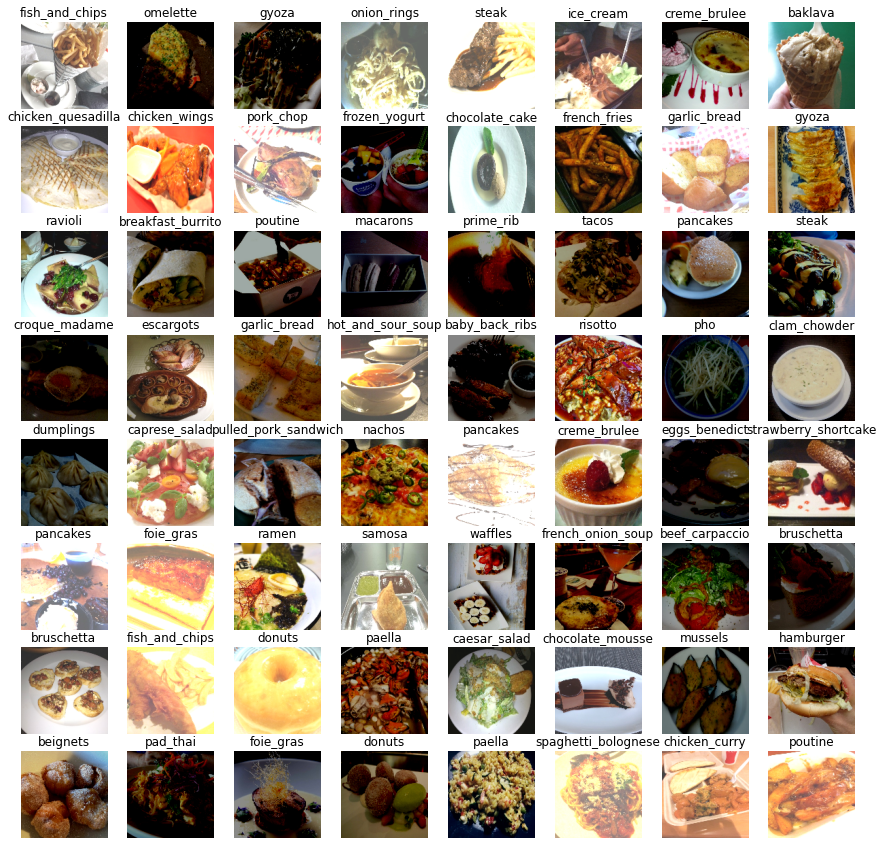

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(15,15))
for images, labels in train_ds.take(1):
  for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(dataset_generator.class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.show()

## Getting the model
We will download the [EfficientNet B0](https://arxiv.org/abs/1905.11946). This is a network optimized to have as little FLOPS for the maximum accuracy. The network can be downloaded with and without pre-trained weights. The pre-trained weights are trained on the [imageNet Challange](http://image-net.org/). These are nature image made with normale camera's of everyday objects (not just food).

In this notebook we are gone to see what a difference it makes to have pre-trained weights VS random weights.

The model that is loaded is without a head because we only have 101 classes not thousands.

Also we add the option to freeze layers. That way their weights are not updated during training.

In [4]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import MaxPooling2D, Dense, Flatten
from tensorflow.keras.models import Model

def create_model(num_frozen_blocks: int = 0):
    n_classes = len(dataset_generator.class_names)
    pre_trained_model = EfficientNetB0(include_top=False, weights="imagenet")

    input_layer = pre_trained_model.input
    max_pool = MaxPooling2D((4, 4))(pre_trained_model.output)

    dense1 = Dense(n_classes, activation="softmax")(max_pool)
    flat = Flatten()(dense1)

    model = Model(input_layer, flat)

    all_layers = ["stem", "block1", "block2", "block3", "block4", "block5", "block6","block7", "top"]
    layers2freeze = tuple(all_layers[:num_frozen_blocks])
    for layer in model.layers:
        if layer.name.startswith(layers2freeze):
            layer.trainable = False

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy']
    )
    return model


## 4 frozen layers
We freeze the first 4 layers. There are not a lot of parameters in the first layers. But these are all very basic features. Meaning the chance these layers needs to be retrained is lower.

In [5]:
model_frozen_base = create_model(4)
history = model_frozen_base.fit(train_ds,
  validation_data=val_ds,
  epochs=N_EPOCHES
)

Epoch 1/20
1105/1105 [==============================] - 687s 622ms/step - loss: 4.7380 - accuracy: 0.0276 - val_loss: 5.4121 - val_accuracy: 0.0126
Epoch 2/20
1105/1105 [==============================] - 167s 151ms/step - loss: 4.0853 - accuracy: 0.0850 - val_loss: 4.6964 - val_accuracy: 0.0200
Epoch 3/20
1105/1105 [==============================] - 164s 149ms/step - loss: 3.6963 - accuracy: 0.1510 - val_loss: 4.8510 - val_accuracy: 0.0126
Epoch 4/20
1105/1105 [==============================] - 162s 147ms/step - loss: 3.4033 - accuracy: 0.2043 - val_loss: 5.0012 - val_accuracy: 0.0116
Epoch 5/20
1105/1105 [==============================] - 155s 140ms/step - loss: 3.1637 - accuracy: 0.2492 - val_loss: 4.7269 - val_accuracy: 0.0112
Epoch 6/20
1105/1105 [==============================] - 154s 139ms/step - loss: 2.9494 - accuracy: 0.2910 - val_loss: 4.9846 - val_accuracy: 0.0164
Epoch 7/20
1105/1105 [==============================] - 151s 137ms/step - loss: 2.7378 - accuracy: 0.3320 - val_

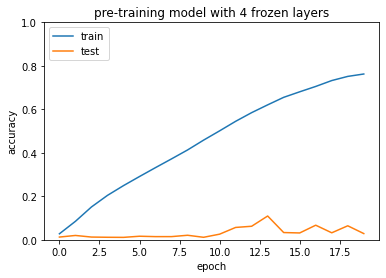

In [6]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('pre-training model with 4 frozen layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

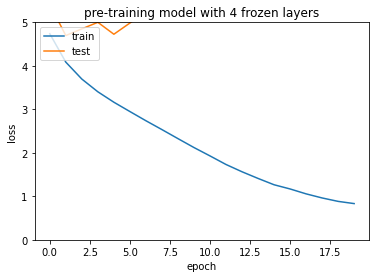

In [7]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('pre-training model with 4 frozen layers')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 8 frozen layers
We freeze the first 8 layers. This are most of the layers but still less then half the parameters.

In [8]:
model_very_frozen = create_model(8)
history = model_very_frozen.fit(train_ds,
  validation_data=val_ds,
  epochs=N_EPOCHES
)

Epoch 1/20
1105/1105 [==============================] - 109s 98ms/step - loss: 15.8695 - accuracy: 0.0101 - val_loss: 15.9654 - val_accuracy: 0.0095
Epoch 2/20
1105/1105 [==============================] - 114s 103ms/step - loss: 15.9555 - accuracy: 0.0101 - val_loss: 15.9654 - val_accuracy: 0.0095
Epoch 3/20
1105/1105 [==============================] - 105s 95ms/step - loss: 15.9556 - accuracy: 0.0101 - val_loss: 15.9654 - val_accuracy: 0.0095
Epoch 4/20
1105/1105 [==============================] - 110s 99ms/step - loss: 15.9555 - accuracy: 0.0101 - val_loss: 15.9654 - val_accuracy: 0.0095
Epoch 5/20
1105/1105 [==============================] - 113s 102ms/step - loss: 15.9556 - accuracy: 0.0101 - val_loss: 15.9654 - val_accuracy: 0.0095
Epoch 6/20
1105/1105 [==============================] - 105s 95ms/step - loss: 15.9555 - accuracy: 0.0101 - val_loss: 15.9654 - val_accuracy: 0.0095
Epoch 7/20
1105/1105 [==============================] - 110s 100ms/step - loss: 15.9555 - accuracy: 0.01

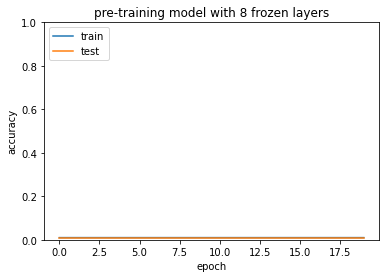

In [9]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('pre-training model with 8 frozen layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

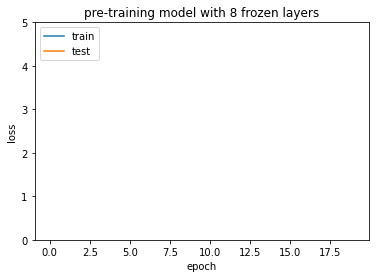

In [10]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('pre-training model with 8 frozen layers')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
model_completely_frozen = create_model(9)
history = model_completely_frozen.fit(train_ds,
  validation_data=val_ds,
  epochs=N_EPOCHES
)

Epoch 1/20
1105/1105 [==============================] - 109s 99ms/step - loss: 5.0733 - accuracy: 0.0096 - val_loss: 5.0384 - val_accuracy: 0.0097
Epoch 2/20
1105/1105 [==============================] - 114s 103ms/step - loss: 5.0569 - accuracy: 0.0101 - val_loss: 5.0013 - val_accuracy: 0.0102
Epoch 3/20
1105/1105 [==============================] - 117s 106ms/step - loss: 5.0562 - accuracy: 0.0096 - val_loss: 5.0539 - val_accuracy: 0.0101
Epoch 4/20
1105/1105 [==============================] - 108s 98ms/step - loss: 5.0650 - accuracy: 0.0094 - val_loss: 4.9778 - val_accuracy: 0.0095
Epoch 5/20
1105/1105 [==============================] - 121s 110ms/step - loss: 5.0490 - accuracy: 0.0104 - val_loss: 4.9948 - val_accuracy: 0.0115
Epoch 6/20
1105/1105 [==============================] - 107s 97ms/step - loss: 5.0590 - accuracy: 0.0109 - val_loss: 5.1408 - val_accuracy: 0.0101
Epoch 7/20
1105/1105 [==============================] - 110s 100ms/step - loss: 5.0526 - accuracy: 0.0108 - val_los

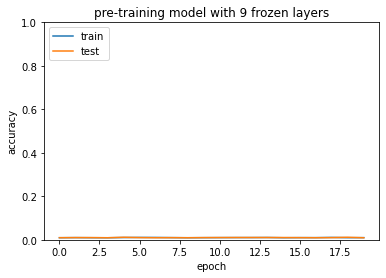

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('pre-training model with 9 frozen layers')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim([0,1])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

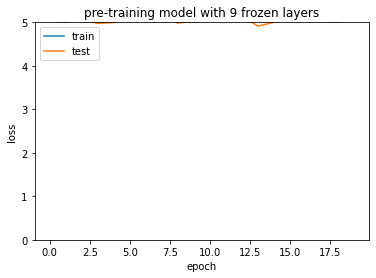

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('pre-training model with 9 frozen layers')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,5])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Conclusion

In this example we can see a small improvement in time.
But once again there is more speed to win by looking into technical optimalizations.

The model got the same amount of data each time and we can see there is enough data for a full training.